In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system','9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [5]:
learning_rate = 0.0001
training_iters = 16000000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.75 # Dropout, probability to keep units

# network config

In [8]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
    conv5 = conv2d(conv4, weights['wc5'], biases['bc5'])
    # Max Pooling (down-sampling)
    conv5 = maxpool2d(conv5, k=2)
    print(conv3.shape)
    print(conv4.shape)
    print(conv5.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv5, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    print(fc1.shape)

    # Output, class prediction
    fc2 = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    print(fc2.shape)
    return fc2

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 16 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 16])),
    # 3x4 conv, 32 inputs, 16 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 16, 16])),
    # 3x4 conv, 64 inputs, 16 outputs
    'wc3': tf.Variable(tf.random_normal([3, 4, 16, 16])),
    # 3x4 conv, 64 inputs, 16 outputs
    'wc4': tf.Variable(tf.random_normal([3, 4, 16, 16])),
    # 3x4 conv, 32 inputs, 16 outputs
    'wc5': tf.Variable(tf.random_normal([3, 4, 16, 16])),
    # fully connected, 2*2*16 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*16, 1024])),
    # 1024 inputs, 14 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([16])),
    'bc2': tf.Variable(tf.random_normal([16])),
    'bc3': tf.Variable(tf.random_normal([16])),
    'bc4': tf.Variable(tf.random_normal([16])),
    'bc5': tf.Variable(tf.random_normal([16])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [9]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 16)
(?, 3, 4, 16)
(?, 3, 4, 16)
(?, 3, 4, 16)
(?, 2, 2, 16)
(?, 1024)
(?, 14)


# train and test

In [10]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 3122381.000000, Accuracy = 0.0399999991059
Performance on test set: Training epochs #1000, Batch Loss = 1215405.0, Accuracy = 0.131999999285
Training epochs #20000: Batch Loss = 3892367.750000, Accuracy = 0.0170000009239
Performance on test set: Training epochs #20000, Batch Loss = 1252224.625, Accuracy = 0.00600000005215
Training epochs #40000: Batch Loss = 1488805.875000, Accuracy = 0.042999997735
Performance on test set: Training epochs #40000, Batch Loss = 926801.5, Accuracy = 0.00600000005215
Training epochs #60000: Batch Loss = 1111177.000000, Accuracy = 0.115000002086
Performance on test set: Training epochs #60000, Batch Loss = 440791.25, Accuracy = 0.00600000005215
Training epochs #80000: Batch Loss = 764924.250000, Accuracy = 0.231999993324
Performance on test set: Training epochs #80000, Batch Loss = 156422.203125, Accuracy = 0.805000007153
Training epochs #100000: Batch Loss = 3044637.750000, Accuracy = 0.0190000012517
Performance on test

Training epochs #920000: Batch Loss = 105406.062500, Accuracy = 0.615999996662
Performance on test set: Training epochs #920000, Batch Loss = 23120.9140625, Accuracy = 0.943000078201
Training epochs #940000: Batch Loss = 75156.679688, Accuracy = 0.724000036716
Performance on test set: Training epochs #940000, Batch Loss = 28703.7226562, Accuracy = 0.942999958992
Training epochs #960000: Batch Loss = 64273.726562, Accuracy = 0.759000062943
Performance on test set: Training epochs #960000, Batch Loss = 31236.921875, Accuracy = 0.942999958992
Training epochs #980000: Batch Loss = 498495.906250, Accuracy = 0.153999999166
Performance on test set: Training epochs #980000, Batch Loss = 21538.5390625, Accuracy = 0.943000078201
Training epochs #1000000: Batch Loss = 95077.648438, Accuracy = 0.627999961376
Performance on test set: Training epochs #1000000, Batch Loss = 20482.0175781, Accuracy = 0.943000078201
Training epochs #1020000: Batch Loss = 76240.234375, Accuracy = 0.708000004292
Performa

Training epochs #1820000: Batch Loss = 36803.355469, Accuracy = 0.758000016212
Performance on test set: Training epochs #1820000, Batch Loss = 11329.4394531, Accuracy = 0.943000018597
Training epochs #1840000: Batch Loss = 25269.902344, Accuracy = 0.811999976635
Performance on test set: Training epochs #1840000, Batch Loss = 12342.8095703, Accuracy = 0.943000078201
Training epochs #1860000: Batch Loss = 198271.953125, Accuracy = 0.264999985695
Performance on test set: Training epochs #1860000, Batch Loss = 7642.79296875, Accuracy = 0.954999983311
Training epochs #1880000: Batch Loss = 40341.414062, Accuracy = 0.726999998093
Performance on test set: Training epochs #1880000, Batch Loss = 7724.90625, Accuracy = 0.943000018597
Training epochs #1900000: Batch Loss = 31597.232422, Accuracy = 0.789000034332
Performance on test set: Training epochs #1900000, Batch Loss = 10542.8232422, Accuracy = 0.942999958992
Training epochs #1920000: Batch Loss = 21955.945312, Accuracy = 0.848000049591
Per

Training epochs #2720000: Batch Loss = 12501.528320, Accuracy = 0.870000004768
Performance on test set: Training epochs #2720000, Batch Loss = 6199.30273438, Accuracy = 0.95500010252
Training epochs #2740000: Batch Loss = 95800.375000, Accuracy = 0.388000011444
Performance on test set: Training epochs #2740000, Batch Loss = 2790.38964844, Accuracy = 0.955000042915
Training epochs #2760000: Batch Loss = 16520.492188, Accuracy = 0.806999981403
Performance on test set: Training epochs #2760000, Batch Loss = 3481.21313477, Accuracy = 0.954999983311
Training epochs #2780000: Batch Loss = 13250.332031, Accuracy = 0.875
Performance on test set: Training epochs #2780000, Batch Loss = 5400.77832031, Accuracy = 0.955000042915
Training epochs #2800000: Batch Loss = 9911.195312, Accuracy = 0.888000011444
Performance on test set: Training epochs #2800000, Batch Loss = 5723.46435547, Accuracy = 0.954999983311
Training epochs #2820000: Batch Loss = 89814.484375, Accuracy = 0.376000016928
Performance 

Training epochs #3620000: Batch Loss = 52645.800781, Accuracy = 0.512000083923
Performance on test set: Training epochs #3620000, Batch Loss = 1194.82067871, Accuracy = 0.975000023842
Training epochs #3640000: Batch Loss = 9820.023438, Accuracy = 0.849999964237
Performance on test set: Training epochs #3640000, Batch Loss = 1693.46972656, Accuracy = 0.961000025272
Training epochs #3660000: Batch Loss = 8141.970703, Accuracy = 0.899000048637
Performance on test set: Training epochs #3660000, Batch Loss = 2641.17993164, Accuracy = 0.961000025272
Training epochs #3680000: Batch Loss = 6052.024902, Accuracy = 0.909000098705
Performance on test set: Training epochs #3680000, Batch Loss = 2666.49389648, Accuracy = 0.961000025272
Training epochs #3700000: Batch Loss = 52238.109375, Accuracy = 0.509000003338
Performance on test set: Training epochs #3700000, Batch Loss = 1157.17553711, Accuracy = 0.975000023842
Training epochs #3720000: Batch Loss = 7656.916992, Accuracy = 0.860999941826
Perfo

Training epochs #4520000: Batch Loss = 3654.944824, Accuracy = 0.912000119686
Performance on test set: Training epochs #4520000, Batch Loss = 840.705078125, Accuracy = 0.975000023842
Training epochs #4540000: Batch Loss = 5132.520020, Accuracy = 0.925999999046
Performance on test set: Training epochs #4540000, Batch Loss = 1431.0123291, Accuracy = 0.961000025272
Training epochs #4560000: Batch Loss = 2387.990234, Accuracy = 0.95400005579
Performance on test set: Training epochs #4560000, Batch Loss = 1392.09899902, Accuracy = 0.961000025272
Training epochs #4580000: Batch Loss = 29674.585938, Accuracy = 0.588999986649
Performance on test set: Training epochs #4580000, Batch Loss = 701.115234375, Accuracy = 0.982000112534
Training epochs #4600000: Batch Loss = 5274.710938, Accuracy = 0.896000087261
Performance on test set: Training epochs #4600000, Batch Loss = 784.384399414, Accuracy = 0.975000023842
Training epochs #4620000: Batch Loss = 3216.113770, Accuracy = 0.93700003624
Performan

Training epochs #5420000: Batch Loss = 3256.254395, Accuracy = 0.944000005722
Performance on test set: Training epochs #5420000, Batch Loss = 722.945800781, Accuracy = 0.975000023842
Training epochs #5440000: Batch Loss = 1371.602051, Accuracy = 0.964000046253
Performance on test set: Training epochs #5440000, Batch Loss = 766.335083008, Accuracy = 0.975000023842
Training epochs #5460000: Batch Loss = 18597.931641, Accuracy = 0.698000013828
Performance on test set: Training epochs #5460000, Batch Loss = 402.731658936, Accuracy = 0.990000128746
Training epochs #5480000: Batch Loss = 3225.950195, Accuracy = 0.921000003815
Performance on test set: Training epochs #5480000, Batch Loss = 579.167541504, Accuracy = 0.981999993324
Training epochs #5500000: Batch Loss = 2327.407471, Accuracy = 0.948000073433
Performance on test set: Training epochs #5500000, Batch Loss = 753.638061523, Accuracy = 0.975000023842
Training epochs #5520000: Batch Loss = 1162.291992, Accuracy = 0.962999999523
Perfor

Training epochs #6320000: Batch Loss = 429.284210, Accuracy = 0.974000036716
Performance on test set: Training epochs #6320000, Batch Loss = 486.864837646, Accuracy = 0.975000023842
Training epochs #6340000: Batch Loss = 14488.637695, Accuracy = 0.709999978542
Performance on test set: Training epochs #6340000, Batch Loss = 280.575622559, Accuracy = 0.991000056267
Training epochs #6360000: Batch Loss = 1453.324219, Accuracy = 0.963000059128
Performance on test set: Training epochs #6360000, Batch Loss = 333.952911377, Accuracy = 0.988000035286
Training epochs #6380000: Batch Loss = 1493.553467, Accuracy = 0.958000063896
Performance on test set: Training epochs #6380000, Batch Loss = 441.559051514, Accuracy = 0.980000078678
Training epochs #6400000: Batch Loss = 1139.028442, Accuracy = 0.968000054359
Performance on test set: Training epochs #6400000, Batch Loss = 437.644012451, Accuracy = 0.976000070572
Training epochs #6420000: Batch Loss = 13697.005859, Accuracy = 0.708000004292
Perfor

Training epochs #7220000: Batch Loss = 8557.779297, Accuracy = 0.761999964714
Performance on test set: Training epochs #7220000, Batch Loss = 198.029174805, Accuracy = 0.991000056267
Training epochs #7240000: Batch Loss = 958.284241, Accuracy = 0.964000046253
Performance on test set: Training epochs #7240000, Batch Loss = 146.909683228, Accuracy = 0.990000009537
Training epochs #7260000: Batch Loss = 1525.940063, Accuracy = 0.966000080109
Performance on test set: Training epochs #7260000, Batch Loss = 174.691436768, Accuracy = 0.982000112534
Training epochs #7280000: Batch Loss = 546.083069, Accuracy = 0.972000002861
Performance on test set: Training epochs #7280000, Batch Loss = 169.248733521, Accuracy = 0.982000112534
Training epochs #7300000: Batch Loss = 8421.355469, Accuracy = 0.754000008106
Performance on test set: Training epochs #7300000, Batch Loss = 178.399993896, Accuracy = 0.991000056267
Training epochs #7320000: Batch Loss = 830.794861, Accuracy = 0.97000002861
Performance

Training epochs #8120000: Batch Loss = 590.350830, Accuracy = 0.977000057697
Performance on test set: Training epochs #8120000, Batch Loss = 37.2717285156, Accuracy = 0.995999991894
Training epochs #8140000: Batch Loss = 705.684692, Accuracy = 0.974999904633
Performance on test set: Training epochs #8140000, Batch Loss = 45.6103210449, Accuracy = 0.996000051498
Training epochs #8160000: Batch Loss = 357.524414, Accuracy = 0.984999895096
Performance on test set: Training epochs #8160000, Batch Loss = 37.8029785156, Accuracy = 0.996000051498
Training epochs #8180000: Batch Loss = 5286.364258, Accuracy = 0.822000026703
Performance on test set: Training epochs #8180000, Batch Loss = 60.127948761, Accuracy = 0.991000115871
Training epochs #8200000: Batch Loss = 438.949280, Accuracy = 0.973000049591
Performance on test set: Training epochs #8200000, Batch Loss = 39.6771774292, Accuracy = 0.996000051498
Training epochs #8220000: Batch Loss = 486.057709, Accuracy = 0.980000019073
Performance o

Training epochs #9040000: Batch Loss = 72.640762, Accuracy = 0.992000043392
Performance on test set: Training epochs #9040000, Batch Loss = 15.368268013, Accuracy = 0.996000051498
Training epochs #9060000: Batch Loss = 3076.868164, Accuracy = 0.86000007391
Performance on test set: Training epochs #9060000, Batch Loss = 19.7726840973, Accuracy = 0.996999979019
Training epochs #9080000: Batch Loss = 244.463440, Accuracy = 0.976000010967
Performance on test set: Training epochs #9080000, Batch Loss = 12.3637561798, Accuracy = 0.997000098228
Training epochs #9100000: Batch Loss = 367.118225, Accuracy = 0.9849999547
Performance on test set: Training epochs #9100000, Batch Loss = 20.285068512, Accuracy = 0.996000051498
Training epochs #9120000: Batch Loss = 121.522278, Accuracy = 0.989999949932
Performance on test set: Training epochs #9120000, Batch Loss = 15.8220405579, Accuracy = 0.996000051498
Training epochs #9140000: Batch Loss = 3146.559570, Accuracy = 0.860999941826
Performance on te

Training epochs #9980000: Batch Loss = 297.367767, Accuracy = 0.984000086784
Performance on test set: Training epochs #9980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10000000: Batch Loss = 57.666191, Accuracy = 0.994000077248
Performance on test set: Training epochs #10000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10020000: Batch Loss = 1666.166260, Accuracy = 0.895000040531
Performance on test set: Training epochs #10020000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #10040000: Batch Loss = 201.848679, Accuracy = 0.980000019073
Performance on test set: Training epochs #10040000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10060000: Batch Loss = 276.069183, Accuracy = 0.98400002718
Performance on test set: Training epochs #10060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10080000: Batch Loss = 81.292839, Accuracy = 0.991999983788
Performance on test set: Training epochs #10080000, Batch Loss = 0.0, A

Training epochs #10940000: Batch Loss = 79.747658, Accuracy = 0.991000056267
Performance on test set: Training epochs #10940000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10960000: Batch Loss = 20.809303, Accuracy = 0.995000004768
Performance on test set: Training epochs #10960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10980000: Batch Loss = 1114.729614, Accuracy = 0.917999982834
Performance on test set: Training epochs #10980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11000000: Batch Loss = 15.921213, Accuracy = 0.994000077248
Performance on test set: Training epochs #11000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11020000: Batch Loss = 217.133728, Accuracy = 0.986999988556
Performance on test set: Training epochs #11020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11040000: Batch Loss = 18.471336, Accuracy = 0.997000038624
Performance on test set: Training epochs #11040000, Batch Lo

Training epochs #11900000: Batch Loss = 46.667000, Accuracy = 0.995000064373
Performance on test set: Training epochs #11900000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11920000: Batch Loss = 26.181702, Accuracy = 0.996000111103
Performance on test set: Training epochs #11920000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11940000: Batch Loss = 417.403992, Accuracy = 0.95400005579
Performance on test set: Training epochs #11940000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11960000: Batch Loss = 29.511028, Accuracy = 0.988999962807
Performance on test set: Training epochs #11960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11980000: Batch Loss = 9.261507, Accuracy = 0.997000098228
Performance on test set: Training epochs #11980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12000000: Batch Loss = 8.230227, Accuracy = 0.998000144958
Performance on test set: Training epochs #12000000, Batch Loss = 

Training epochs #12860000: Batch Loss = 40.216148, Accuracy = 0.992000043392
Performance on test set: Training epochs #12860000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12880000: Batch Loss = 8.618397, Accuracy = 0.997000098228
Performance on test set: Training epochs #12880000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12900000: Batch Loss = 258.057098, Accuracy = 0.961000025272
Performance on test set: Training epochs #12900000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12920000: Batch Loss = 12.618738, Accuracy = 0.996000051498
Performance on test set: Training epochs #12920000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12940000: Batch Loss = 22.436447, Accuracy = 0.998000085354
Performance on test set: Training epochs #12940000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12960000: Batch Loss = 4.471009, Accuracy = 0.996999979019
Performance on test set: Training epochs #12960000, Batch Loss =

Training epochs #13820000: Batch Loss = 5.112835, Accuracy = 0.999000072479
Performance on test set: Training epochs #13820000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13840000: Batch Loss = 10.705649, Accuracy = 0.997000038624
Performance on test set: Training epochs #13840000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #13860000: Batch Loss = 288.514801, Accuracy = 0.953999996185
Performance on test set: Training epochs #13860000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13880000: Batch Loss = 8.666089, Accuracy = 0.995000004768
Performance on test set: Training epochs #13880000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13900000: Batch Loss = 14.886482, Accuracy = 0.996999979019
Performance on test set: Training epochs #13900000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13920000: Batch Loss = 0.254562, Accuracy = 0.999000072479
Performance on test set: Training epochs #13920000, Batch Loss = 0.0, Accur

Training epochs #14780000: Batch Loss = 64.630463, Accuracy = 0.999000072479
Performance on test set: Training epochs #14780000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14800000: Batch Loss = 7.640146, Accuracy = 0.995000064373
Performance on test set: Training epochs #14800000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14820000: Batch Loss = 184.306030, Accuracy = 0.97100007534
Performance on test set: Training epochs #14820000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14840000: Batch Loss = 23.254442, Accuracy = 0.993000030518
Performance on test set: Training epochs #14840000, Batch Loss = 0.714161157608, Accuracy = 0.996999979019
Training epochs #14860000: Batch Loss = 1.171916, Accuracy = 0.999000072479
Performance on test set: Training epochs #14860000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14880000: Batch Loss = 2.297060, Accuracy = 0.999000072479
Performance on test set: Training epochs #14880000, Ba

Training epochs #15740000: Batch Loss = 10.263264, Accuracy = 0.996000051498
Performance on test set: Training epochs #15740000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15760000: Batch Loss = 0.031947, Accuracy = 0.999000072479
Performance on test set: Training epochs #15760000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #15780000: Batch Loss = 118.910065, Accuracy = 0.960999965668
Performance on test set: Training epochs #15780000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15800000: Batch Loss = 4.583143, Accuracy = 0.998000085354
Performance on test set: Training epochs #15800000, Batch Loss = 2.04644608498, Accuracy = 0.996999979019
Training epochs #15820000: Batch Loss = 3.054174, Accuracy = 0.998000025749
Performance on test set: Training epochs #15820000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15840000: Batch Loss = 0.717600, Accuracy = 0.997000098228
Performance on test set: Training epochs #15840000, Batch Loss = 

# performance visualization

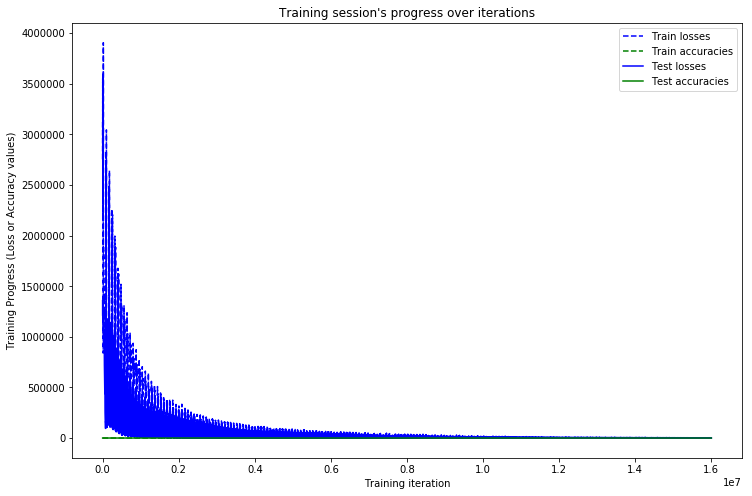

In [11]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Best Testing Accuracy: 100.000011921%

Precision: 97.7713562889%
Recall: 97.71%
f1_score: 97.6318941994%

Confusion Matrix:
[[    0     3     0     0     0     5     0    10     0     0     0     0
      0]
 [    6   797    26     0    27    24    21     4     5     0     0     1
      0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0  2865    10     0    11     0     0     0     3
      0]
 [    0    26     1     0     2   319     0     0     0     0     0     0
      0]
 [    0     7     2     0     0     0 14486     0     0     0     0     0
      0]
 [    0    66    16     0    39    36     5   372     0     0     0     1
      0]
 [    0     0     0     0     0     0     0     0   132     0     0     0
      0]
 [    0     0     2     0     0     0     0     0     0     2     0     0
      0]
 [    0     0     0     0     0     0     0   

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


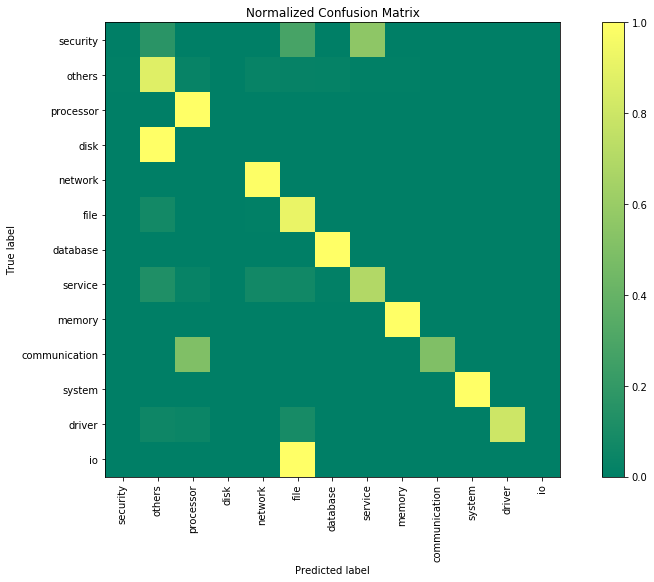

In [10]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Best Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)